# Drive Authentification

In [ ]:
#download pydrive
%pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
your_module = drive.CreateFile({'id':'[google_drive_file_id]'})

In [ ]:
#To mount Google drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

In [0]:
#Change directory to the main folder with datasets
%cd "gdrive/My Drive/CAD/Dermoscopy/Pipeline"

/content/gdrive/My Drive/CAD/Dermoscopy/Pipeline


In [0]:
#Check where are you
%ls

In [0]:
import tensorflow as tf
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Hyperparameters












































































































































































































































































































































































































































In [0]:
batch_size = 8
height = 450
width = 450
channels = 3
input_shape = (width, height, channels)
model_name = 'efficientnet4_unfreeze_regularization_all'
NUM_TRAIN = 5700
NUM_VAL = 300
epochs = 40

#number of train steps
TRAIN_STEP = NUM_TRAIN//batch_size
print(TRAIN_STEP)
VAL_STEP = NUM_VAL//batch_size
print(VAL_STEP)

model_path ='efficientnet4weights.05-0.28.hdf5'
full_ds = True
#for reprodusability
seed = 17
#l2 lamda
penalty = 0.01


712
37


# Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet
from efficientnet.keras import preprocess_input
import numpy as np
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


# Model

**EfficientNet-B0** (pre-trained with imagenet)

In [ ]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [0]:
from keras import regularizers
model = enet.EfficientNetB4(include_top=False, input_shape=(450,450,3), pooling='avg', weights='imagenet')
num_encode_layers=0
for layer in model.layers:
    num_encode_layers=num_encode_layers+1
print(num_encode_layers)
for layer in model.layers[:200]:
   if isinstance(layer, keras.layers.normalization.BatchNormalization):
      layer.trainable = True  
   else:
      layer.trainable = False
        
# adding regularization
regularizer = tf.keras.regularizers.l2(penalty)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)    

for layer in model.layers[200:]:
    layer.trainable = True
    
# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512,kernel_regularizer=regularizers.l2(penalty))(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128,kernel_regularizer=regularizers.l2(penalty))(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(inputs = model.input, outputs = predictions)
model_final.summary()
model_final.load_weights('efficientnet4_unfreeze_regularization_all_unfreeze200_weights.05-0.42.hdf5')

# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
model_final.compile(loss='binary_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])



# Generators

In [0]:

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
if full_ds:

      # this is the augmentation configuration we will use for training
      train_datagen = ImageDataGenerator(
              preprocessing_function=preprocess_input,
              validation_split=0.05)


      # this is a generator that will read pictures found in
      # subfolers of 'train_val', and indefinitely generate
      # batches of augmented image data
      train_generator = train_datagen.flow_from_directory(
              'train_val',  # this is the target directory
              target_size=(height, width),  # all images will be resized0
              batch_size=batch_size,
              class_mode='binary',
              subset='training',
              shuffle=True,
              seed=seed)
      validation_generator = train_datagen.flow_from_directory('train_val',
              target_size=(height, width),
              batch_size=batch_size,
              class_mode='binary',
              subset='validation',
              seed=seed,
              shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

else:
        # this is the augmentation configuration we will use for training
      train_datagen = ImageDataGenerator(
              rescale=1./255,
              zoom_range=0.6,
              horizontal_flip=True,
              rotation_range=20,
              brightness_range=(0.4, 1.2),
              fill_mode='constant')

      # this is the augmentation configuration we will use for testing:
      # only rescaling
      test_datagen = ImageDataGenerator(rescale=1./255)

      # this is a generator that will read pictures found in
      # subfolers of 'train', and indefinitely generate
      # batches of augmented image data
      train_generator = train_datagen.flow_from_directory(
              'train',  # this is the target directory
              target_size=(height, width),  # all images will be resized
              batch_size=batch_size,
              class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

      # this is a similar generator, for validation data
      validation_generator = test_datagen.flow_from_directory('val',
              target_size=(height, width),
              batch_size=batch_size,
              class_mode='binary')
        

Found 5700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


**Show generators output (augmentation)**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 1. 0. 0. 1. 0. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 1. 0. 1. 1. 1. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 1. 0. 1. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 1. 1. 1. 1. 1. 1. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 1. 1. 0. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 0. 1. 1. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 1. 0. 0. 1. 1. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 1. 0. 1. 0. 1. 1. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 0. 0. 1. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 1. 1. 1. 1. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 1. 1. 0. 0. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 0. 0. 1. 0. 1.]


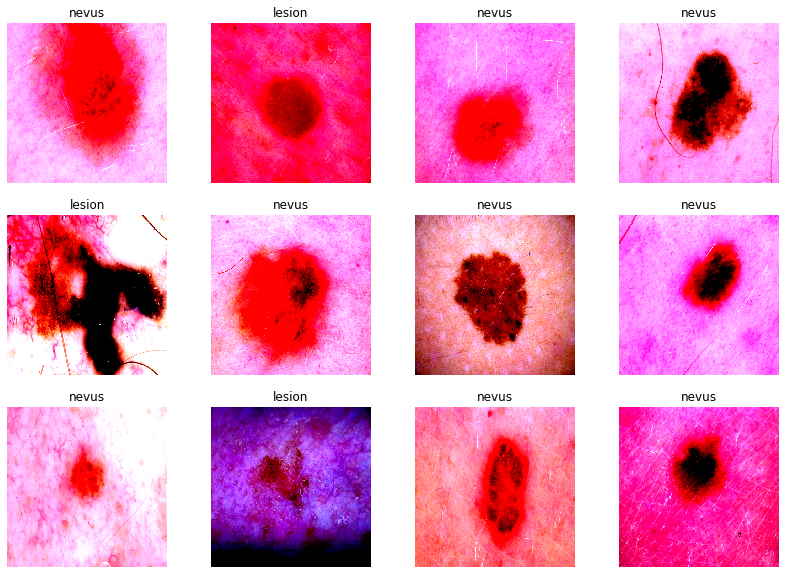

In [0]:
#this is a piece of code to show output of the generator

import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (img,lbl) = data[a]
        print(lbl)
        for label,image in zip(lbl,img):
          if label==1.:
            l='nevus'
          elif label==0.:
            l='lesion'
          image=np.array(image)     
          im = ax.imshow(image)
          ax.set_title(l)
          ax.axis('off')
        pass
        
    plt.show()
class_plot(train_generator)

# Callbacks

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,CSVLogger
#to save weights every epoch
filepath = model_name+'_unfreeze200_'+'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#to reduce learning rate on plateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.0001,  min_lr=0.000001)
#to save metrics to csv
csv_logger = CSVLogger('log'+model_name+'.csv', append=True, separator=';')
callbacks_list = [csv_logger,checkpoint, reduceLROnPlat]


# Train model

In [0]:
#print("Training....")
history = model_final.fit_generator(train_generator,steps_per_epoch=TRAIN_STEP,validation_data=validation_generator,validation_steps=VAL_STEP, epochs = epochs, callbacks = callbacks_list )

# Evaluation

**Learning curves**

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  'the code to plot loss and accuracy'
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
plot_history(history)

In [0]:
#helper functions for evaluation

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [0]:
#to plot confusion matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


results = model_final.evaluate(validation_generator)
for name, value in zip(model_final.metrics_names, results):
  print(name, ': ', value)

validation_generator.shuffle = False
validation_generator.index_array = None
test_pred = model_final.predict(validation_generator)
test_labels = []

for i in range(VAL_STEP):
    img,lbl=next(validation_generator)
    for k in lbl:
       test_labels.append(k)
print(len(test_labels))



plot_cm(test_labels, test_pred)

**ROC, AUC**

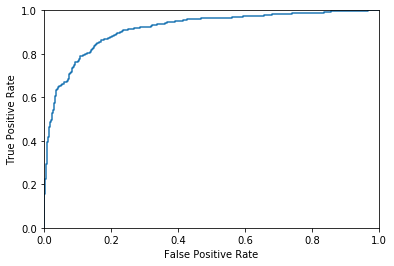

In [0]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  

 
fpr , tpr , thresholds = roc_curve ( test_labels , test_pred)

plot_roc_curve (fpr,tpr)

# Test prediction


In [ ]:
import pandas as pd
import os
from keras.preprocessing.image import load_img

prediction_filename="5"+model_name+'test_pred'
test_dir='test'
threshold=0.5
test_sampels=os.listdir(test_dir)
ID=[]
test_predictions=[]

for i in test_sampels:
  image = load_img(os.path.join(test_dir,i), target_size=(224, 224))
  print(i)
  # convert the image to an array
  img = img_to_array(image)
  print(img.shape)
  # expand dimensions so that it represents a single 'sample'

  image_norm = np.expand_dims(img, axis=0)
  image_norm = preprocess_input(image_norm)
  pred = model_final.predict(image_norm)
  print(pred[0,0])
  if pred > threshold:
    lbl=1
  else:
    lbl=0
  ID.append(str(i))
  test_predictions.append(lbl)

TP=pd.DataFrame(list(zip(ID, test_predictions)),
columns=['id','prediction'])
TP.to_csv(prediction_filename+".csv", encoding='utf-8', index=False)


# Prediction confidence



In [ ]:
import pandas as pd
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
prediction_filename="5_confidence"+model_name+'test_pred'
test_dir='test'

threshold=0.5
test_sampels=os.listdir(test_dir)
ID=[]
test_predictions=[]

for i in test_sampels:
  image = load_img(os.path.join(test_dir,i), target_size=(224, 224))
  print(i)
  # convert the image to an array
  img = img_to_array(image)
  print(img.shape)
  # expand dimensions so that it represents a single 'sample'

  image_norm = np.expand_dims(img, axis=0)
  image_norm = preprocess_input(image_norm)
  pred = model_final.predict(image_norm)
  print(pred)
  ID.append(str(i))
  test_predictions.append(pred[0,0])

TP=pd.DataFrame(list(zip(ID, test_predictions)),
columns=['id','confidence'])
TP.to_csv(prediction_filename+".csv", encoding='utf-8', index=False)


In [ ]:
#this is the code to visualise feature maps and save them to a folder

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt 
from numpy import expand_dims
import os
val_dir='val'
ixs = [1,4,12,14]
layer_dict = dict([(layer.name, layer) for layer in model_final.layers])
print(layer_dict)
layer_name = 'block1a_project_conv'

model_final = Model(inputs=model_final.inputs, outputs=layer_dict[layer_name].output)

# load the image with the required shape
img = load_img(os.path.join(val_dir,'les','ls0001.jpg'), target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img =img/255
# get feature map for first hidden layer
feature_maps = model_final.predict(img)
print(len(feature_maps))
print(feature_maps[0].shape)

it=0
square = 8
index = 5
for _ in range(square):
  index=1
  for _ in range(square):
    plt.figure(figsize=(20,20))
    #ax = plt.subplot(square, square, index)
    #ax.set_xticks([])
    #ax.set_yticks([])

    plt.imshow(feature_maps[0, :, :, index-1], cmap='gray')
    index += 1
    it=it+1
    plt.savefig(os.path.join('maps',layer_name+str(it)+'.jpg'))

        
plt.show()



# Other experiments

**EfficientNet-B3**

In [0]:

def mbConv_block(input_data, block_arg):
    """Mobile Inverted Residual block along with Squeeze and Excitation block."""
    kernel_size = block_arg.kernel_size
    num_repeat= block_arg.num_repeat
    input_filters= block_arg.input_filters
    output_filters= output_filters.kernel_size
    expand_ratio= block_arg.expand_ratio
    id_skip= block_arg.id_skip
    strides= block_arg.strides
    se_ratio= block_arg.se_ratio
    # Genişleme Evresi
    expanded_filters =  input_filters * expand_ratio
    x = Conv2D(expanded_filters, 1,  padding='same',  use_bias=False)(input_data)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Squeeze and expand steps
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    se = Conv2D(squeezed_filters , 1, activation=swish_activation, padding='same')(se)
    se = Conv2D(expanded_filters, 1, activation='sigmoid', padding='same')(se)
    x = multiply([x, se])
    # Outputs
    x = Conv2D(output_filters, 1, padding='same', use_bias=False)
    x = BatchNormalization()(x)
    return x


In [0]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [0]:
model = enet.EfficientNetB3(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')
num_encode_layers=0
for layer in model.layers:
    num_encode_layers=num_encode_layers+1
print(num_encode_layers)
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = False
    
# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(inputs = model.input, outputs = predictions)
model_final.summary()
#model_final.load_weights(model_path)

# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
model_final.compile(loss='binary_crossentropy',
              optimizer=Adam(0.1),
              metrics=['accuracy'])







231
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
________________________________________________________________________________________

## Vgg16

In [ ]:
inp= Input( (x_wid, y_wid, n_channels))
model_name='vgg16'
sz = (x_wid, y_wid, n_channels)
x = Input(sz)
inputs = x

# build the VGG16 network
base_model = VGG16(weights='imagenet', input_shape=(x_wid, y_wid, n_channels),input_tensor=x, include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# add the model on top of the convolutional base

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:1]:
    layer.trainable = False
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


## Vgg19

In [ ]:
inp= Input( (x_wid, y_wid, n_channels))
model_name='vgg19'
sz = (x_wid, y_wid, n_channels)
x = Input(sz)
inputs = x

# build the VGG19 network
base_model = VGG19(weights='imagenet', input_shape=(x_wid, y_wid, n_channels),input_tensor=x, include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# add the model on top of the convolutional base

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:1]:
    layer.trainable = False
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


## Inception

In [0]:
from keras.applications.densenet import DenseNet201
n_train_layers=15
from keras.applications.inception_v3 import InceptionV3
model_name= 'inception_v3'
inp= Input( (x_wid, y_wid, n_channels))
sz = (x_wid, y_wid, n_channels)
x = Input(sz)
inputs = x

# create the base pre-trained model
base_model=InceptionV3(weights='imagenet', input_shape=(x_wid, y_wid, n_channels),input_tensor=x, include_top=False, pooling='none')
for layer in base_model.layers[:n_train_layers]:
    layer.trainable = False
for layer in base_model.layers:
    layer.trainable = True


print(base_model)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 111, 111, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 111, 111, 32) 0           batch_normalization_471[0][0]    
____________________________________________________________________________________________

## Attention

In [0]:
from keras.layers import Dense, Dropout,  Conv2D, Input, Lambda, Flatten, TimeDistributed
from keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector
from keras.models import Model
from keras import backend as K

import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.engine.topology import Layer
import tensorflow as tf
from keras.callbacks import TensorBoard
model_name='attention1'
def MultiHeadsAttModel(l=8*8, d=512, dv=64, dout=512, nv = 8 ):

    v1 = Input(shape = (l, d))
    q1 = Input(shape = (l, d))
    k1 = Input(shape = (l, d))

    v2 = Dense(dv*nv, activation = "relu")(v1)
    q2 = Dense(dv*nv, activation = "relu")(q1)
    k2 = Dense(dv*nv, activation = "relu")(k1)

    v = Reshape([l, nv, dv])(v2)
    q = Reshape([l, nv, dv])(q2)
    k = Reshape([l, nv, dv])(k2)
        
    att = Lambda(lambda x: K.batch_dot(x[0],x[1] ,axes=[-1,-1]) / np.sqrt(dv),
                 output_shape=(l, nv, nv))([q,k])# l, nv, nv
    att = Lambda(lambda x:  K.softmax(x) , output_shape=(l, nv, nv))(att)

    out = Lambda(lambda x: K.batch_dot(x[0], x[1],axes=[4,3]),  output_shape=(l, nv, dv))([att, v])
    out = Reshape([l, d])(out)
    
    out = Add()([out, q1])

    out = Dense(dout, activation = "relu")(out)

    return  Model(inputs=[q1,k1,v1], outputs=out)

class NormL(Layer):

    def __init__(self, **kwargs):
        super(NormL, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.a = self.add_weight(name='kernel', 
                                      shape=(1,input_shape[-1]),
                                      initializer='ones',
                                      trainable=True)
        self.b = self.add_weight(name='kernel', 
                                      shape=(1,input_shape[-1]),
                                      initializer='zeros',
                                      trainable=True)
        super(NormL, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        eps = 0.000001
        mu = K.mean(x, keepdims=True, axis=-1)
        sigma = K.std(x, keepdims=True, axis=-1)
        ln_out = (x - mu) / (sigma + eps)
        return ln_out*self.a + self.b

    def compute_output_shape(self, input_shape):
        return input_shape
    
if __name__ == '__main__':   

    nb_classes = 2
    
    inp = Input(shape = (x_wid,y_wid,3))
    print()
    x = Conv2D(32,(2,2),activation='relu', padding='same')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64,(2,2),activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64*3,(2,2),activation='relu')(x)
    
    if True:
        x = Reshape([6*6,64*3])(x)    
        att = MultiHeadsAttModel(l=6*6, d=64*3 , dv=8*3, dout=32, nv = 8 )
        x = att([x,x,x])
        x = Reshape([6,6,32])(x)   
        x = NormL()(x)
    
    x = Flatten()(x) 
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])